# Февраль 2018

# Tinkoff Data Science Challenge
## Задача
Выбор кредита от Tinkoff.ru

В credit_train.csv содержится 170746 строк с данными о клиентах сети магазинов электроники, в этих магазинах они подали заявки на кредит. Колонка open_account_flg содержит 1 если клиент выбрал Тинькофф и 0 в противном случае. В credit_test.csv содержится 91940 строк с данными, для каждой строки следует предсказать возьмет ли соответствующий ей человек кредит в Тинькофф.
## Описание полей
https://boosters.pro/champ_3
## Метрика
AUC
## Победитель

|Участник|Решений|Результат|Последнее решение|
|:---|---|---|---|
|Станислав Семёнов|22|0.7807|2017-02-27 22:59:08|

# Clean Data

In [1]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

from matplotlib import pylab as plt
%matplotlib inline
import seaborn as sns

import pymorphy2
import json

from tqdm import tqdm_notebook as tqdm

In [2]:
train = pd.read_csv('data/credit_train.csv', encoding='cp1251', sep=';', index_col='client_id')

In [3]:
train.head()

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg
client_id,,,,,,,,,,,,,,
1,M,48,MAR,UMN,"59998,00",10,1.6,"0,770249",GRD,КРАСНОДАРСКИЙ КРАЙ,30000.0,1.0,1.0,0
2,F,28,MAR,UMN,"10889,00",6,1.1,"0,248514",GRD,МОСКВА,43000.0,2.0,0.0,0
3,M,32,MAR,SPC,"10728,00",12,1.1,"0,459589",SCH,ОБЛ САРАТОВСКАЯ,23000.0,5.0,0.0,0
4,F,27,DIV,SPC,"12009,09",12,1.1,"0,362536",GRD,ОБЛ ВОЛГОГРАДСКАЯ,17000.0,2.0,0.0,0
5,M,45,MAR,SPC,"16908,89",10,1.1,"0,421385",SCH,ЧЕЛЯБИНСКАЯ ОБЛАСТЬ,25000.0,1.0,0.0,0


In [4]:
train.shape

(170746, 14)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170746 entries, 1 to 170746
Data columns (total 14 columns):
gender                  170746 non-null object
age                     170746 non-null int64
marital_status          170746 non-null object
job_position            170746 non-null object
credit_sum              170746 non-null object
credit_month            170746 non-null int64
tariff_id               170746 non-null float64
score_shk               170746 non-null object
education               170746 non-null object
living_region           170554 non-null object
monthly_income          170745 non-null float64
credit_count            161516 non-null float64
overdue_credit_count    161516 non-null float64
open_account_flg        170746 non-null int64
dtypes: float64(4), int64(3), object(7)
memory usage: 19.5+ MB


## Пока не показательно, так как есть косяки в записях некоторых фич

In [6]:
train.describe()

,age,credit_month,tariff_id,monthly_income,credit_count,overdue_credit_count,open_account_flg
count,170746.000000,170746.000000,170746.000000,170745.000000,161516.000000,161516.000000,170746.000000
mean,36.497283,10.980749,1.323900,40138.288354,2.107308,0.046070,0.176028
std,10.546008,3.536698,0.235813,25044.205336,1.777128,0.211548,0.380845
min,18.000000,3.000000,1.000000,5000.000000,0.000000,0.000000,0.000000
25%,28.000000,10.000000,1.100000,25000.000000,1.000000,0.000000,0.000000
50%,34.000000,10.000000,1.320000,35000.000000,2.000000,0.000000,0.000000
75%,43.000000,12.000000,1.600000,50000.000000,3.000000,0.000000,0.000000
max,71.000000,36.000000,1.960000,950000.000000,21.000000,3.000000,1.000000


# Обработка пропусков

In [7]:
def value_counts(vector):
    
    try:
        vector = DataFrame(Series(vector).value_counts())
    except TypeError:
        if type(vector.values[0]) == list or type(vector.values[0]) == set:
            vector = vector.map(lambda x: ' '.join(x))
            vector = DataFrame(Series(vector).value_counts())
        
    vector.reset_index(inplace=True)
    vector.columns = ['value', 'n_entries']
    
    return vector

In [8]:
def get_missing_df(dataset):
    
    dataset_shape = dataset.shape[0]
    
    missing_df = DataFrame()
    
    for col in dataset:
        
        tmp_nans_count = dataset[col].dropna().shape[0]
        
        if tmp_nans_count != dataset_shape:
            
            missing_df.loc[col, 'Missing N'] = dataset_shape - tmp_nans_count
            missing_df.loc[col, 'Missing %'] = (dataset_shape-tmp_nans_count)*100/dataset.shape[0]
            
            
    return missing_df

In [9]:
missing_df = get_missing_df(train)
missing_df

,Missing N,Missing %
living_region,192.0,0.112448
monthly_income,1.0,0.000586
credit_count,9230.0,5.405690
overdue_credit_count,9230.0,5.405690


## Месячный доход (monthly_income)

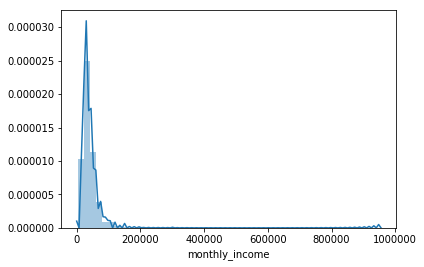

In [10]:
sns.distplot(train.monthly_income.dropna())

### Заменим пропущенное значение на медиану

In [11]:
train.monthly_income.fillna(train.monthly_income.median(), inplace=True)

### Подробнее рассмотрим "длинный хвост" на предмет выбросов

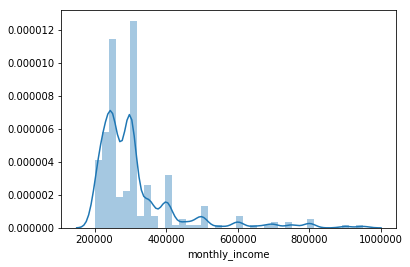

In [12]:
sns.distplot(train.monthly_income[train.monthly_income > 200000])

## Регион проживания (living_region)

In [13]:
get_missing_df(train)

,Missing N,Missing %
living_region,192.0,0.112448
credit_count,9230.0,5.405690
overdue_credit_count,9230.0,5.405690


### Есть пропуски и некоректно записаны значения

In [14]:
value_counts(train.living_region)

,value,n_entries
0,ОБЛ МОСКОВСКАЯ,12228
1,КРАСНОДАРСКИЙ КРАЙ,7457
2,САНКТ-ПЕТЕРБУРГ,5632
3,МОСКВА,5529
4,ТАТАРСТАН РЕСП,5187
5,РЕСП БАШКОРТОСТАН,4833
6,ОБЛ ИРКУТСКАЯ,4080
7,СВЕРДЛОВСКАЯ ОБЛ,4006
8,МОСКВА Г,3647
9,ОБЛ НИЖЕГОРОДСКАЯ,3555


### Обработка неккоректно записанных данных

In [15]:
def prepare_word(word):
    
    return ''.join([w for w in word if w.isalpha()]).replace('ё', 'е')


def clean_living_region_0(region_descr):
    
    region_descr = [prepare_word(w) for w in str(region_descr).lower().split()]
    region_descr = [w for w in region_descr if w]
    
    return region_descr

In [16]:
living_region = train.living_region.map(clean_living_region_0)

In [17]:
value_counts(living_region)

,value,n_entries
0,обл московская,12228
1,краснодарский край,7457
2,респ башкортостан,6306
3,санктпетербург,5632
4,москва,5529
5,татарстан респ,5187
6,обл иркутская,4080
7,свердловская обл,4006
8,москва г,3647
9,обл нижегородская,3555


In [18]:
living_region[:15]

client_id
1                          [краснодарский, край]
2                                       [москва]
3                             [обл, саратовская]
4                           [обл, волгоградская]
5                         [челябинская, область]
6                         [ставропольский, край]
7                           [обл, нижегородская]
8                              [московская, обл]
9     [хантымансийский, автономный, округ, югра]
10                        [край, ставропольский]
11                              [санктпетербург]
12                          [респ, башкортостан]
13                          [обл, архангельская]
14                         [хантымансийский, ао]
15                          [респ, башкортостан]
Name: living_region, dtype: object

In [19]:
def get_unique_words(vector):
    
    words = []

    for i in living_region:
        words.extend(i)
    
    return value_counts(words)

### Достаем уникальные слова

In [20]:
get_unique_words(living_region)

,value,n_entries
0,обл,82152
1,край,24680
2,респ,21961
3,московская,12836
4,область,11973
5,москва,9260
6,краснодарский,8355
7,санктпетербург,8302
8,татарстан,7666
9,свердловская,7316


In [21]:
STOPWORDS_living_region = ['край', 'г', 'респ', 'обл', 'округ', 'ао', 'рн', 'автономная', 'республика',
                           'федеральный', 'округ', 'область', 'автономный']


def clean_living_region_1(sample_list):
    
    sample_list = [w for w in set(sample_list) if w not in STOPWORDS_living_region]
    output = []
    
    for i in sample_list:
        
        for stopword in sorted([w for w in STOPWORDS_living_region if len(w) > 2], key=lambda x: len(x), reverse=True):
                
            i = i.replace(stopword, '')
            
        output.append(i)
            
    return [w for w in output if w]

In [22]:
living_region = living_region.map(clean_living_region_1)

In [23]:
get_unique_words(living_region)

,value,n_entries
0,московская,12837
1,москва,9260
2,краснодарский,8355
3,санктпетербург,8302
4,татарстан,7667
5,свердловская,7316
6,башкортостан,6466
7,челябинская,5154
8,самарская,5104
9,ставропольский,4617


In [24]:
value_counts(living_region)

,value,n_entries
0,московская,12836
1,москва,9260
2,краснодарский,8355
3,санктпетербург,8302
4,татарстан,7667
5,свердловская,7316
6,башкортостан,6466
7,челябинская,5154
8,самарская,5104
9,ставропольский,4617


### Как можно было бы по-другому
Также для этого можно было использовать расстояние дамерау-ливенштейна, но осталось всего лишь 108 уникальных, которые также имеют некоректные (пример: "россия", "гмосква" и тд), которые в данном случае легче преобразовать путем замены на nan

In [25]:
small_regions_counts = value_counts(living_region)
small_regions_counts = {small_regions_counts.loc[w, 'value']: small_regions_counts.loc[w, 'n_entries']
                        for w in small_regions_counts.index}
small_regions_counts = {w: int(small_regions_counts[w]) for w in small_regions_counts if small_regions_counts[w] < 10}

In [26]:
small_regions_counts

{'': 2,
 'брянский': 1,
 'восток дальний': 1,
 'гмосква': 1,
 'годинцово московская': 1,
 'гусьхрустальный': 1,
 'камчатская': 3,
 'москвоская': 1,
 'мытищинский': 1,
 'орел': 1,
 'приволжский': 1,
 'россия': 2,
 'саха': 1,
 'чувашия чувашская': 1,
 'эвенкийский': 1}

### Сохраним, чтобы использовать в пайплайне

In [27]:
with open('data/small_regions_counts.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(small_regions_counts, ensure_ascii=False))

In [28]:
def clean_living_region_2(region):
    
    region = ' '.join(region)
    
    if not region:
        return 'nan'
    
    if region in small_regions_counts.keys():
        return 'nan'
    else:
        return region

In [29]:
living_region = living_region.map(clean_living_region_2)

In [30]:
value_counts(living_region)

,value,n_entries
0,московская,12836
1,москва,9260
2,краснодарский,8355
3,санктпетербург,8302
4,татарстан,7667
5,свердловская,7316
6,башкортостан,6466
7,челябинская,5154
8,самарская,5104
9,ставропольский,4617


### Для данного этапа более чем достаточно
Есть идея в дальнейшем обогатить наши данные, тогда рассмотрим регионы более подробно

### Оформим наше преобразование более грамотно
Перепишу все, чтобы в дальнейшим оформить в пайплайн

In [31]:
def prepare_word(word):
    
    return ''.join([w for w in word if w.isalpha()]).replace('ё', 'е')

STOPWORDS_living_region = ['край', 'г', 'респ', 'обл', 'округ', 'ао', 'рн', 'автономная', 'республика',
                           'федеральный', 'округ', 'область', 'автономный']

with open('data/small_regions_counts.json', 'r', encoding='utf-8') as f:
    small_regions_counts = json.loads(f.read())

In [32]:
def prepare_region(sample, nan_value='missing'):
     
    sample = [prepare_word(w) for w in str(sample).lower().split()]
    sample = [w for w in sample if w]
    
    sample_list = [w for w in set(sample) if w not in STOPWORDS_living_region]
    output = []
    
    for i in sample_list:
        
        for stopword in sorted([w for w in STOPWORDS_living_region if len(w) > 2], key=lambda x: len(x), reverse=True):
                
            i = i.replace(stopword, '')
            
        output.append(i)
        
    output = [w for w in output if w]
    
    region = ' '.join(output)
    
    if region in small_regions_counts.keys() or not region or region == 'nan':
        return nan_value
    else:
        return region

In [33]:
train.living_region = train.living_region.map(prepare_region)

In [34]:
value_counts(train.living_region)

,value,n_entries
0,московская,12836
1,москва,9260
2,краснодарский,8355
3,санктпетербург,8302
4,татарстан,7667
5,свердловская,7316
6,башкортостан,6466
7,челябинская,5154
8,самарская,5104
9,ставропольский,4617


### Добавим индикатор того, что значение пропущено

In [35]:
train['living_region_is_missing'] = train.living_region.map(lambda x: 'Missing' if x == 'missing' else 'Not missing')

## Количество кредитов у клиента (credit_count) и количество просроченных кредитов клиента (overdue_credit_count)

In [36]:
get_missing_df(train)

,Missing N,Missing %
credit_count,9230.0,5.40569
overdue_credit_count,9230.0,5.40569


### Убедимся в том, что это действительно одни и те же клиенты

In [37]:
credit_count_nan_indexes = set(train.credit_count.index) - set(train.credit_count.dropna().index)

In [38]:
overdue_credit_count_nan_indexes = set(train.overdue_credit_count.index) - set(train.overdue_credit_count.dropna().index)

In [39]:
credit_count_nan_indexes == overdue_credit_count_nan_indexes

True

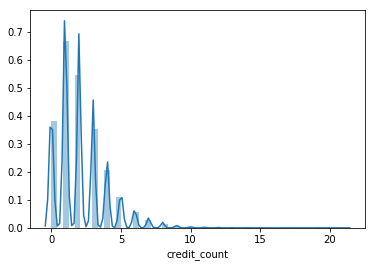

In [40]:
sns.distplot(train.credit_count.dropna())

In [41]:
value_counts(train.credit_count)

,value,n_entries
0,1.0,45279
1,2.0,36998
2,0.0,25806
3,3.0,23918
4,4.0,14113
5,5.0,7543
6,6.0,3915
7,7.0,1962
8,8.0,1007
9,9.0,476


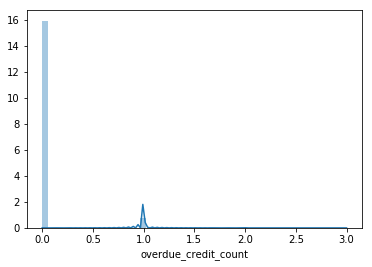

In [42]:
sns.distplot(train.overdue_credit_count.dropna())

In [43]:
value_counts(train.overdue_credit_count)

,value,n_entries
0,0.0,154135
1,1.0,7326
2,2.0,50
3,3.0,5


In [44]:
get_missing_df(train)

,Missing N,Missing %
credit_count,9230.0,5.40569
overdue_credit_count,9230.0,5.40569


### Добавим фичу, которые явно указывают, что есть пропуск

In [45]:
train['credit_count_is_missing'] = train.credit_count.map(lambda x: 'Missing' if str(x) == 'nan' else 'Not missing')

### Для бейслайн решения просто введем новую категорию nan

In [46]:
train.credit_count = train.credit_count.map(lambda x: 'mising' if str(x) == 'nan' else str(x))
train.overdue_credit_count = train.overdue_credit_count.map(lambda x: 'mising' if str(x) == 'nan' else str(x))

In [47]:
value_counts(train.credit_count)

,value,n_entries
0,1.0,45279
1,2.0,36998
2,0.0,25806
3,3.0,23918
4,4.0,14113
5,mising,9230
6,5.0,7543
7,6.0,3915
8,7.0,1962
9,8.0,1007


## Разберемся с неправильным типов данных некоторых фичей

In [48]:
train.head()

,gender,age,marital_status,job_position,credit_sum,credit_month,tariff_id,score_shk,education,living_region,monthly_income,credit_count,overdue_credit_count,open_account_flg,living_region_is_missing,credit_count_is_missing
client_id,,,,,,,,,,,,,,,,
1,M,48,MAR,UMN,"59998,00",10,1.6,"0,770249",GRD,краснодарский,30000.0,1.0,1.0,0,Not missing,Not missing
2,F,28,MAR,UMN,"10889,00",6,1.1,"0,248514",GRD,москва,43000.0,2.0,0.0,0,Not missing,Not missing
3,M,32,MAR,SPC,"10728,00",12,1.1,"0,459589",SCH,саратовская,23000.0,5.0,0.0,0,Not missing,Not missing
4,F,27,DIV,SPC,"12009,09",12,1.1,"0,362536",GRD,волгоградская,17000.0,2.0,0.0,0,Not missing,Not missing
5,M,45,MAR,SPC,"16908,89",10,1.1,"0,421385",SCH,челябинская,25000.0,1.0,0.0,0,Not missing,Not missing


In [49]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170746 entries, 1 to 170746
Data columns (total 16 columns):
gender                      170746 non-null object
age                         170746 non-null int64
marital_status              170746 non-null object
job_position                170746 non-null object
credit_sum                  170746 non-null object
credit_month                170746 non-null int64
tariff_id                   170746 non-null float64
score_shk                   170746 non-null object
education                   170746 non-null object
living_region               170746 non-null object
monthly_income              170746 non-null float64
credit_count                170746 non-null object
overdue_credit_count        170746 non-null object
open_account_flg            170746 non-null int64
living_region_is_missing    170746 non-null object
credit_count_is_missing     170746 non-null object
dtypes: float64(2), int64(3), object(11)
memory usage: 27.1+ MB


In [50]:
def get_unique_symbols(vector, nums=True, ru_sym=True, en_sym=True):
    
    stop_symbols = []
    
    if not nums:
        stop_symbols.extend([str(w) for w in list(range(10))])
        
    if not ru_sym:
        stop_symbols.extend([chr(w) for w in range(1040, 1103)])
        
    if not en_sym:
        stop_symbols.extend([chr(w) for w in list(range(65, 90)) + list(range(97, 123))])

    unique_chars = set()
    
    for sample in vector:
        for symbol in str(sample):
            if symbol not in stop_symbols:
                unique_chars.add(symbol)
            
    return list(unique_chars)

In [51]:
get_unique_symbols(train.credit_sum)

['2', '3', '0', '7', '4', '8', ',', '1', '6', '9', '5']

In [52]:
train.credit_sum = train.credit_sum.map(lambda x: float(str(x).replace(',', '.')))

In [53]:
get_unique_symbols(train.score_shk)

['2', '3', '9', '7', '4', '8', ',', '1', '6', '0', '5']

In [54]:
train.score_shk = train.score_shk.map(lambda x: float(str(x).replace(',', '.')))

In [55]:
train.tariff_id = train.tariff_id.map(lambda x: '{}_id'.format(x))

In [56]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 170746 entries, 1 to 170746
Data columns (total 16 columns):
gender                      170746 non-null object
age                         170746 non-null int64
marital_status              170746 non-null object
job_position                170746 non-null object
credit_sum                  170746 non-null float64
credit_month                170746 non-null int64
tariff_id                   170746 non-null object
score_shk                   170746 non-null float64
education                   170746 non-null object
living_region               170746 non-null object
monthly_income              170746 non-null float64
credit_count                170746 non-null object
overdue_credit_count        170746 non-null object
open_account_flg            170746 non-null int64
living_region_is_missing    170746 non-null object
credit_count_is_missing     170746 non-null object
dtypes: float64(3), int64(3), object(10)
memory usage: 27.1+ MB


In [57]:
train['target'] = train.open_account_flg.map(lambda x: 'Approved' if x == 1 else 'Not approved')

In [58]:
train.drop('open_account_flg', axis=1, inplace=True)

### Первые приготовления готовы для EDA

In [59]:
train.to_csv('data/train_prepared_by_clean_data.csv', encoding='utf-8')